In [1]:
from utils import * 

from matplotlib.colors import LogNorm

runs = base.sort_values('model/num_parameters')
os.environ["WANDB_SILENT"] = "true"

N_MODELS = 20

/Users/henrywilliams/Documents/programming/python/ai/malbert-test/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Weight Similarity 

In [2]:
def get_norm(selected):
    tokenizer, base_model, pretrained_model = get_model(selected.ID)

    diff = []

    for P_b, P_p in zip(base_model.parameters(), pretrained_model.parameters()):
        if len(P_b.shape) <= 1:
            diff.append(torch.linalg.vector_norm(P_b - P_p))
        else: 
            diff.append(torch.linalg.matrix_norm(P_b - P_p))
            
    diff = torch.tensor(diff)
    return diff.mean(), diff.std()

weight_norm = []
param_count = []

for i, run in tqdm(enumerate(runs.itertuples()), total=len(runs)):
    weight_norm.append(get_norm(run))
    param_count.append(run._7)

    if i > N_MODELS: 
        break

 25%|██▍       | 21/85 [01:00<03:02,  2.86s/it]


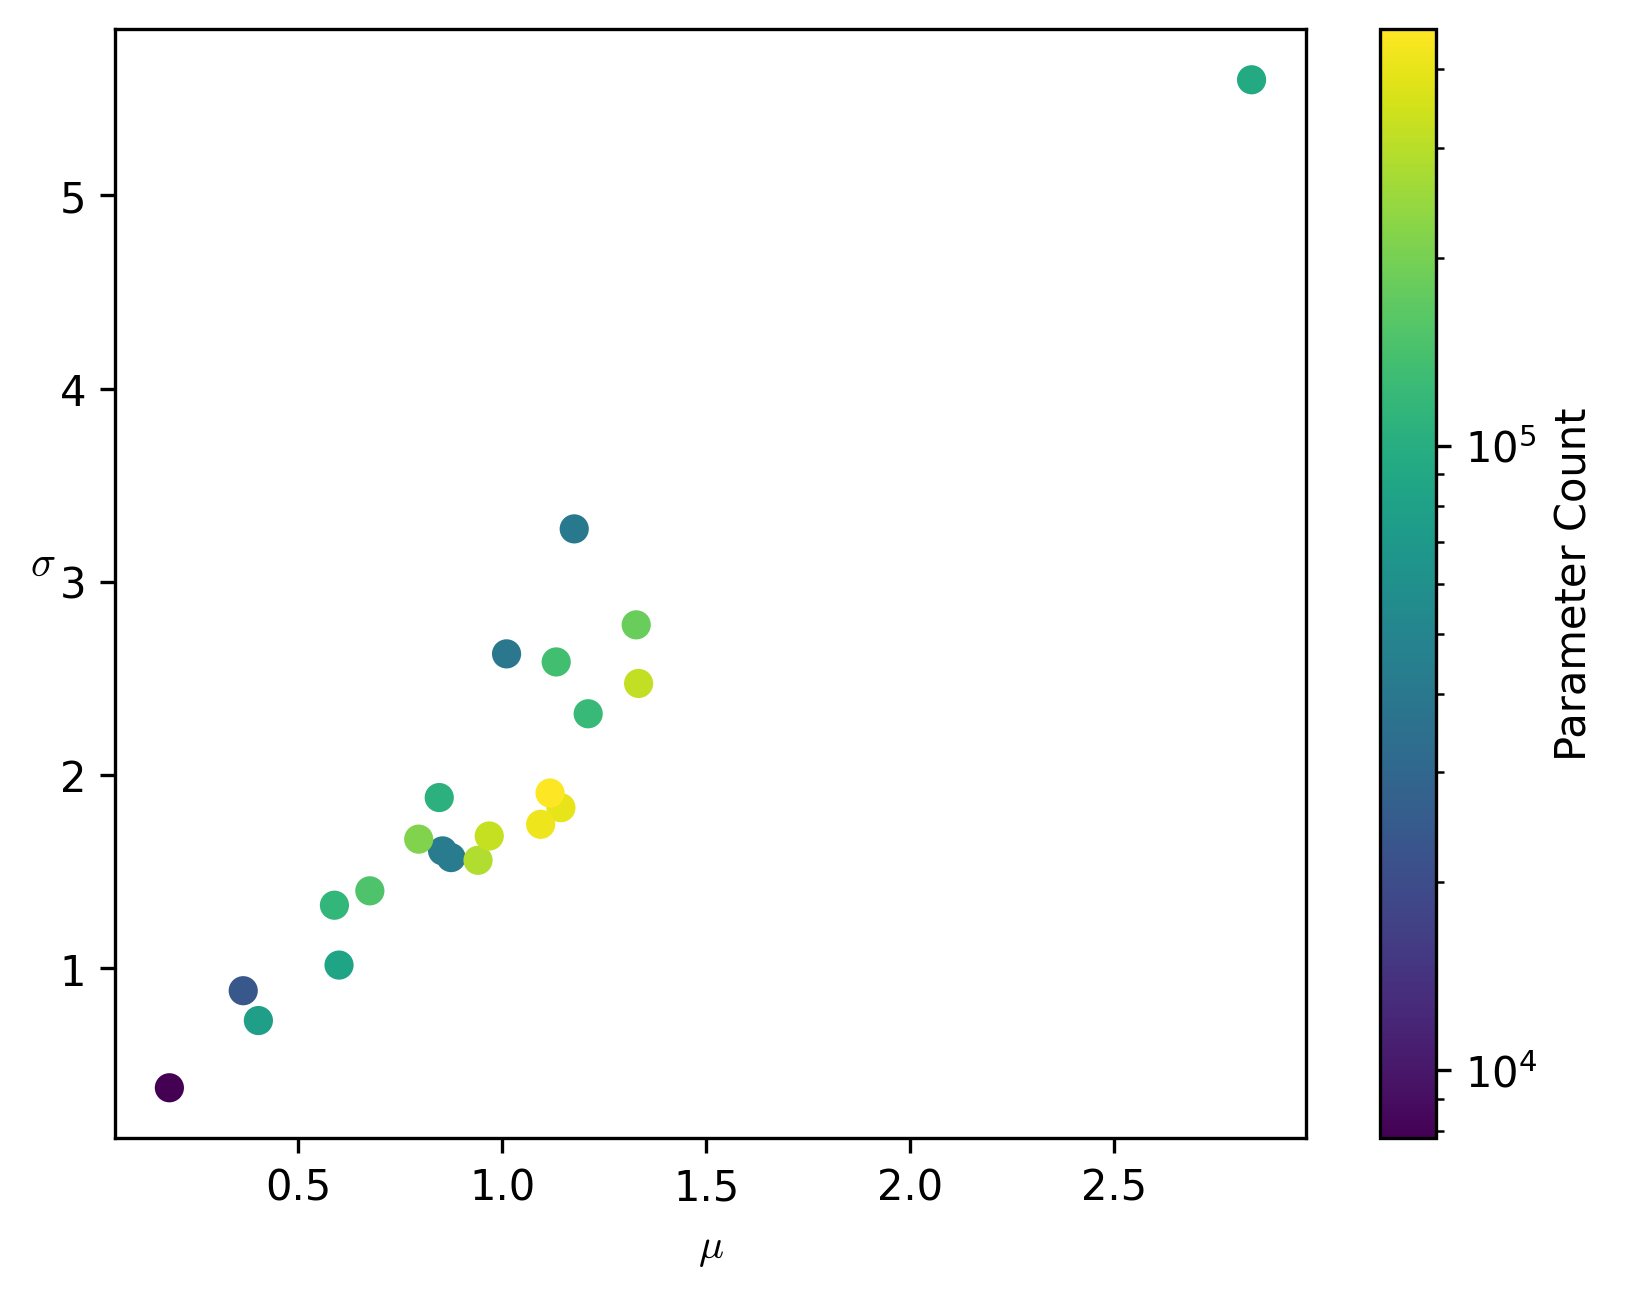

In [3]:
weight_norm = torch.tensor(weight_norm)

cmap = np.array(param_count)
plt.figure(dpi=300)
sc = plt.scatter(weight_norm[:, 0], weight_norm[:, 1], c=cmap, norm=LogNorm())
plt.xlabel("$\mu$")
plt.ylabel("$\sigma$", rotation=0)
cbar = plt.colorbar(sc)
cbar.set_label("Parameter Count")
plt.show()

# Embedding Similarity 

In [4]:

def CKA(X: torch.Tensor, Y: torch.Tensor) -> torch.Tensor:
    def center(X: torch.Tensor) -> torch.Tensor:
        return X - X.mean(dim=0, keepdim=True)

    X = center(X)
    Y = center(Y)

    sim = torch.norm(Y.T @ X, p='fro') ** 2
    X_norm = torch.norm(X.T @ X, p='fro')
    Y_norm = torch.norm(Y.T @ Y, p='fro')

    return sim / (X_norm * Y_norm + 1e-12)


results = {
    "cosine": [], 
    "l2": [],
    "cka": []
}

sample = dataset['test'].shuffle().select([1])

loop = tqdm(enumerate(runs.itertuples()), total=len(runs))
for i, run in loop:
    try: 
        loop.set_postfix_str("Downloading... ")
        tokenizer, base_model, pretrained_model = get_model(run.ID)
        loop.set_postfix_str("Downloading... Done ")
    except: 
        continue

    base_embeddings = get_embeddings(base_model, sample, tokenizer)
    pretrained_embeddings = get_embeddings(pretrained_model, sample, tokenizer)

    base_embeddings = base_embeddings.view(-1, base_embeddings.shape[-1])
    pretrained_embeddings = pretrained_embeddings.view(-1, pretrained_embeddings.shape[-1])

    cosine_sim = []
    l2_sim = []
    cka_sim = []

    for E_b, E_p in zip(base_embeddings, pretrained_embeddings):
        cosine_sim.append(torch.cosine_similarity(E_b.unsqueeze(0), E_p.unsqueeze(0)))
        l2_sim.append(torch.linalg.norm(E_b - E_p))
        cka_sim.append(CKA(E_p, E_b))

    results['cosine'].append(torch.tensor(cosine_sim))
    results['l2'].append(torch.tensor(l2_sim))
    results['cka'].append(torch.tensor(cka_sim))

    if i > N_MODELS: 
        break


 25%|██▍       | 21/85 [02:11<06:40,  6.26s/it, Downloading... Done ]


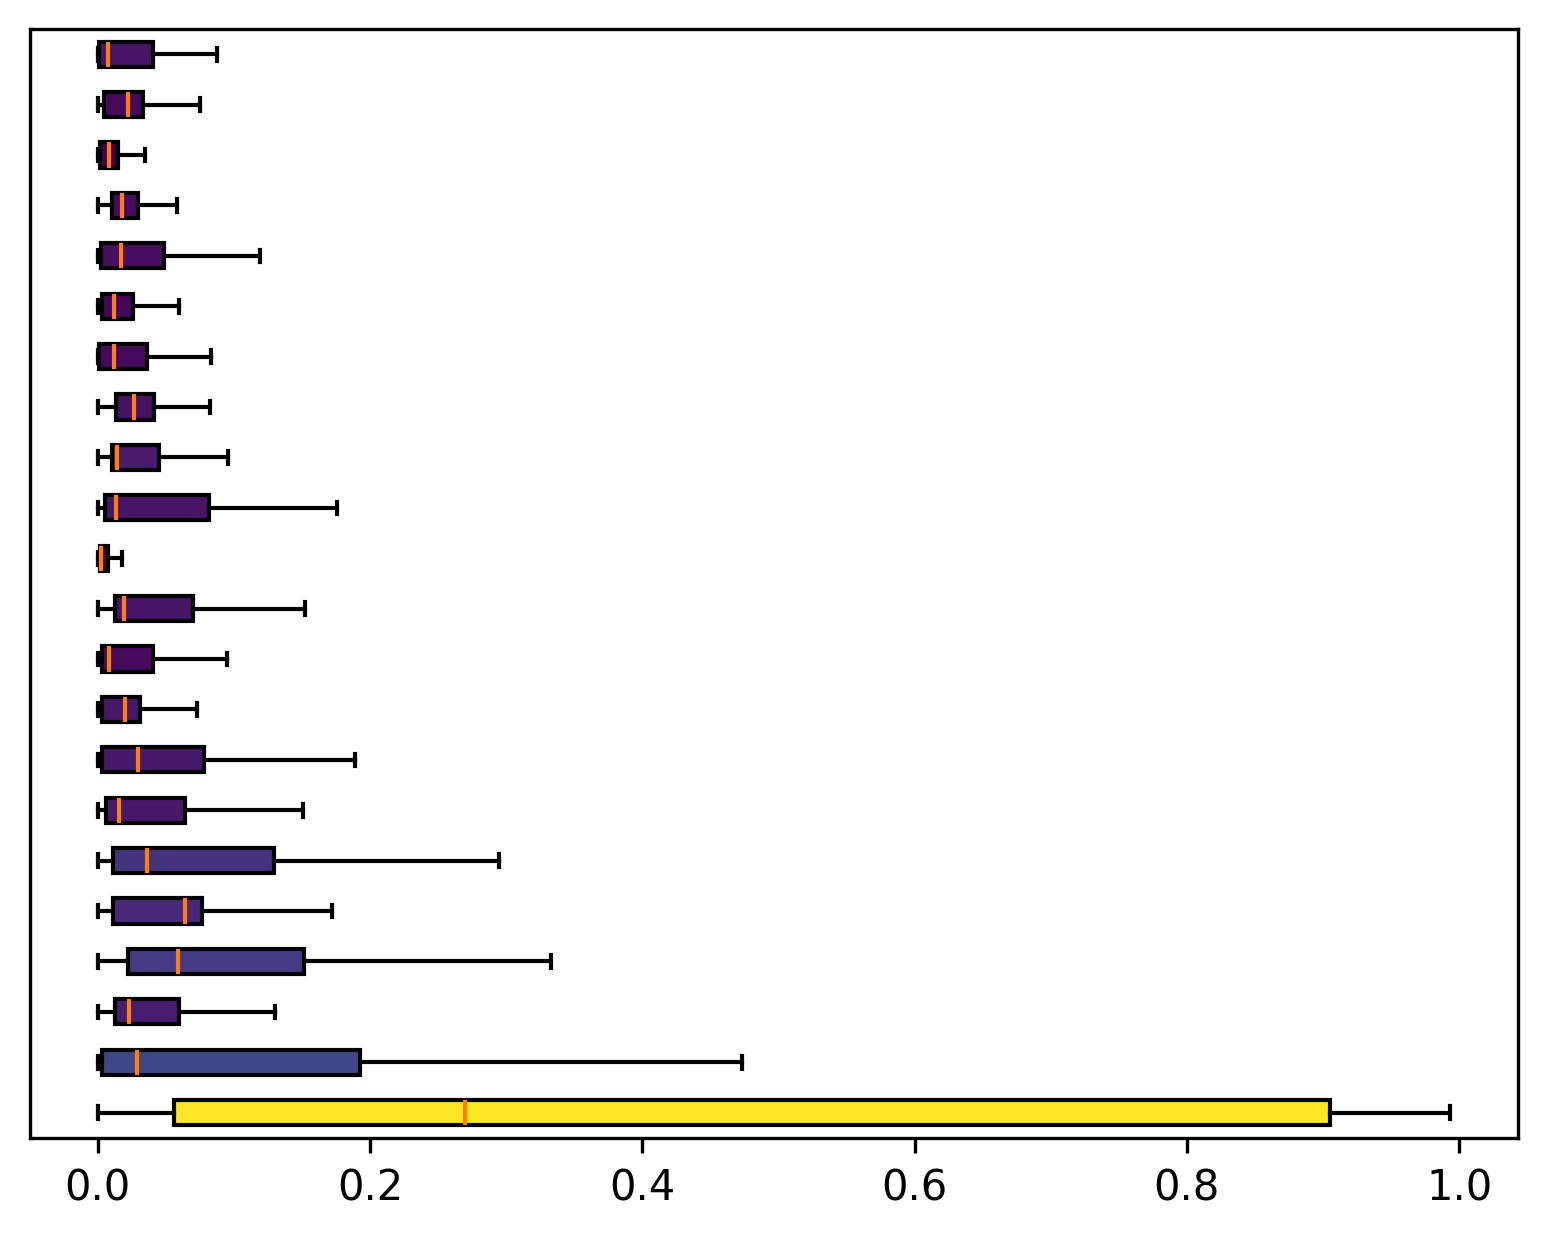

In [11]:
plt.figure(dpi=300)
bp = plt.boxplot(results['cka'], showfliers=False, orientation='horizontal', patch_artist=True)

cmap = mpl.cm.ScalarMappable(cmap='viridis')
means = [torch.mean(a) for a in results['cka']]

for p,c in zip(bp['boxes'], cmap.to_rgba(means)):
    p.set_facecolor(c)
    
plt.yticks([])
plt.show()